INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


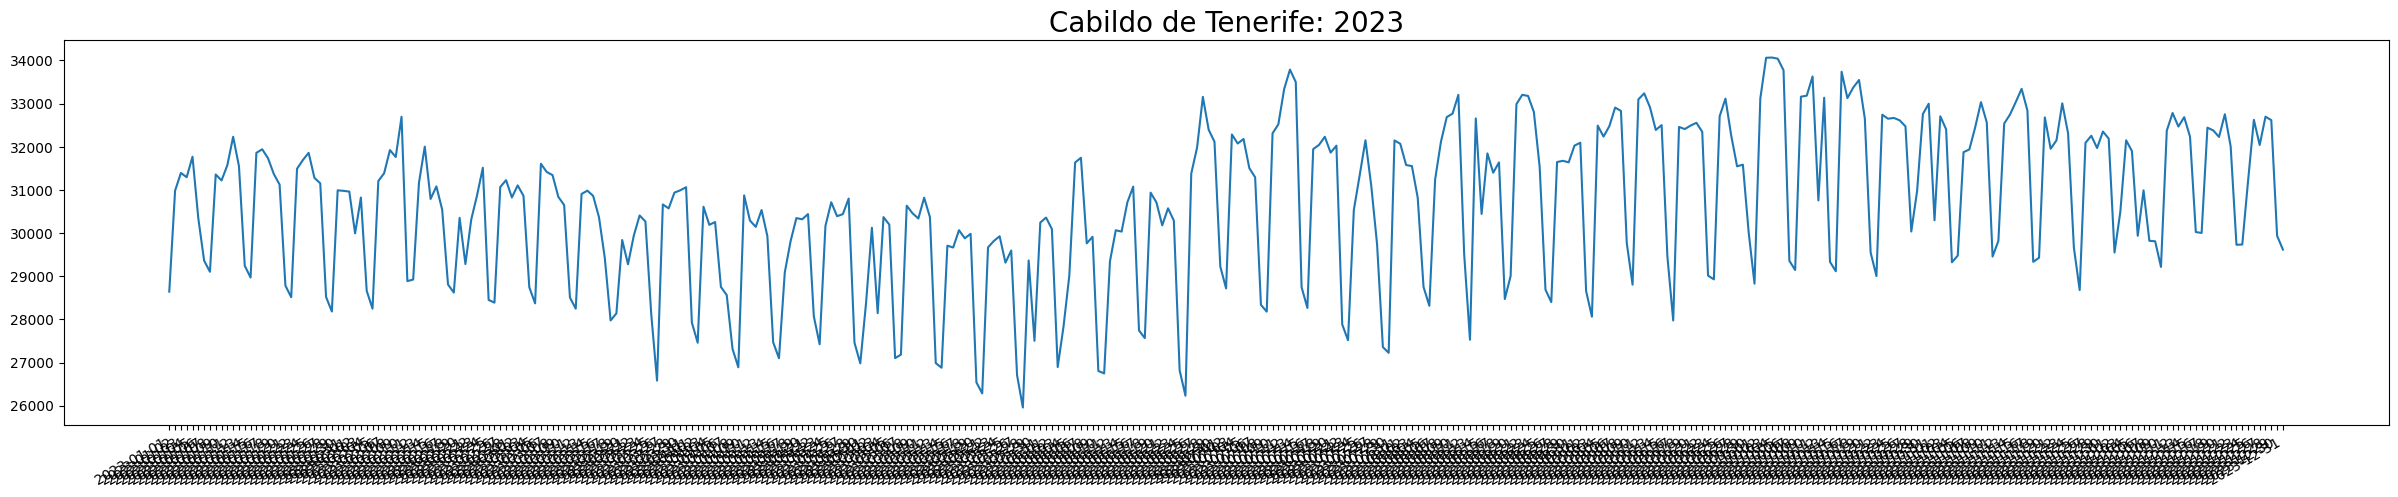

In [232]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('../data/consumo-energetico-2023.csv') # 2023 empieza en enero y termina en diciembre

def daily(df):
    grouped = df.groupby('fecha')['consumo'].sum().reset_index()
    
    if len(grouped) > 1 and grouped.iloc[-1, 1] < 0.5 * grouped.iloc[-2, 1]:
        grouped = grouped.iloc[:-1]  # Remove last two entries if the last value is too low

    return grouped.rename(columns={'fecha': 'date', 'consumo': 'value'})

timeseries = daily(df)

plt.figure(figsize=(30,5))
plt.title(f'Cabildo de Tenerife: {timeseries['date'].values[0][:4]}', size = 20)
plt.plot(timeseries['date'].values, timeseries['value'].values)
plt.xticks(rotation=30, ha='right')
plt.show()

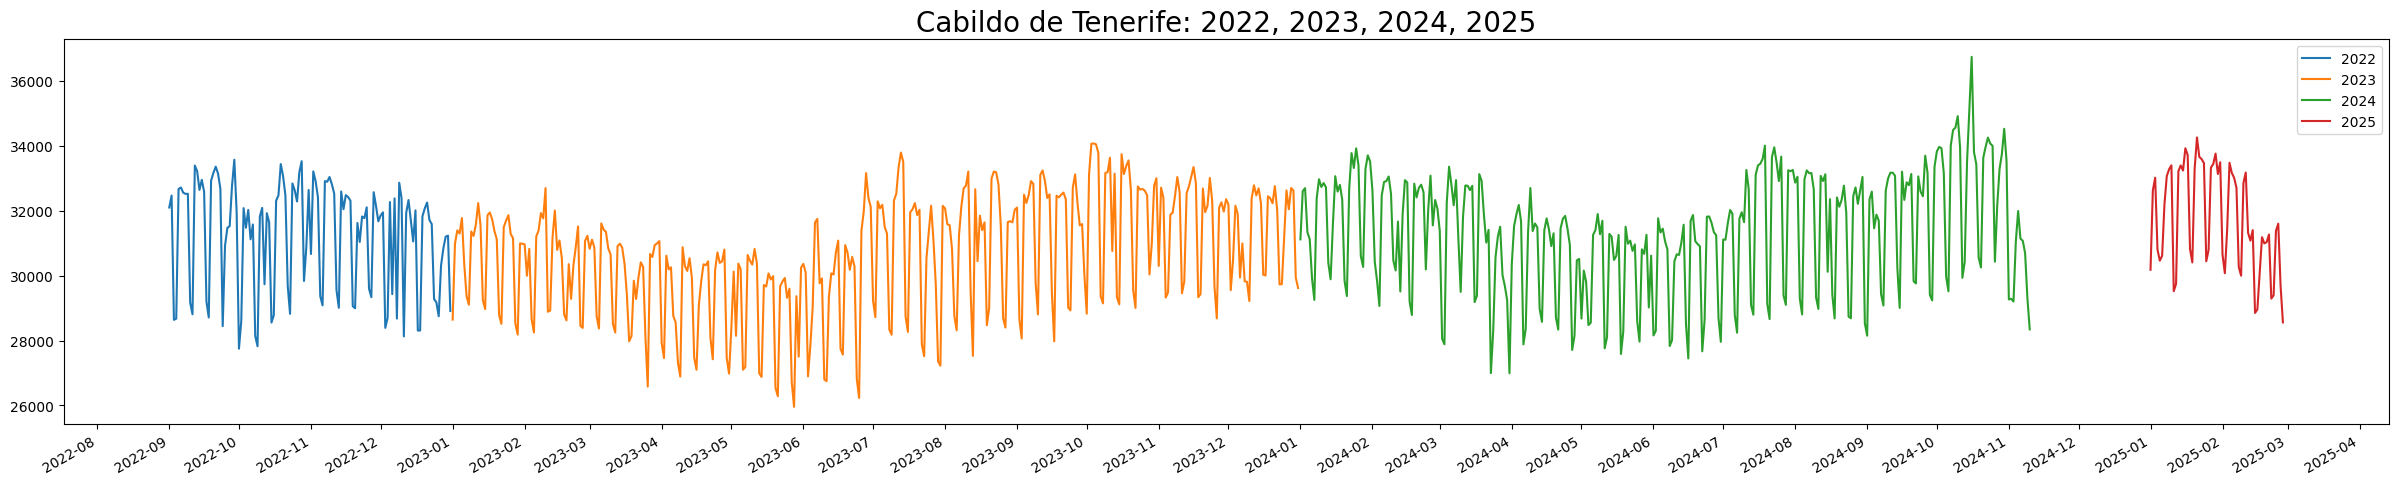

In [233]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def daily(df):
    grouped = df.groupby('fecha')['consumo'].sum().reset_index()
    if len(grouped) > 1 and grouped.iloc[-1, 1] < 0.5 * grouped.iloc[-2, 1]:
        grouped = grouped.iloc[:-1]  # Remove last entry if it's incomplete
    grouped = grouped.rename(columns={'fecha': 'date', 'consumo': 'value'})
    # Convert the date column to datetime
    grouped['date'] = pd.to_datetime(grouped['date'])
    return grouped

years = [2022, 2023, 2024, 2025]

plt.figure(figsize=(30, 5))
for year in years:
    df = pd.read_csv(f'../data/consumo-energetico-{year}.csv')
    timeseries = daily(df)
    plt.plot(timeseries['date'], timeseries['value'], label=str(year))

plt.title('Cabildo de Tenerife: ' + ', '.join(map(str, years)), size=20)
plt.xticks(rotation=30, ha='right')
plt.legend()

ax = plt.gca()
# Set x-axis ticks to every month
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.show()


# Entrenamiento de septiembre 2022 a octubre 2024 y testeo noviembre 2024

In [ ]:
years = [2022, 2023, 2024]

total = pd.DataFrame()
for year in years:
    df = pd.read_csv(f'../data/consumo-energetico-{year}.csv')
    timeseries = daily(df)
    total = pd.concat([total, timeseries])

In [289]:
total = total.reset_index(drop = True)

sept22_oct23 = total[:int(len(total['date'].values)-41)]

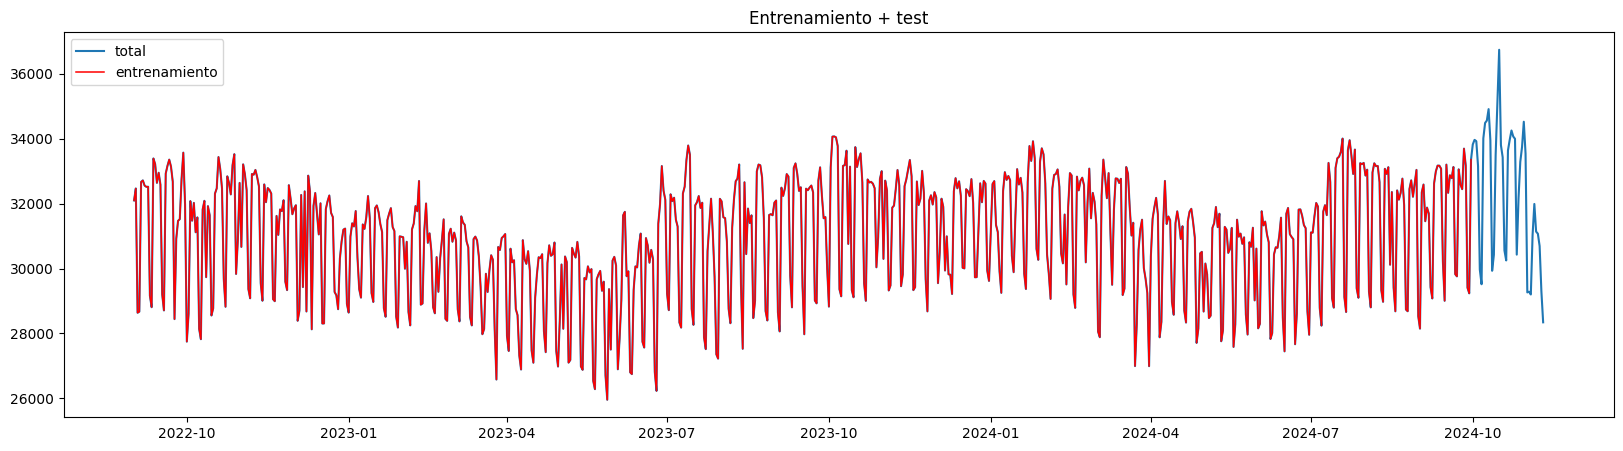

In [300]:
plt.figure(figsize=(20,5))
plt.title('Entrenamiento + test')
plt.plot(total['date'].values, total['value'].values, label = 'total')
plt.plot(sept22_oct23['date'].values, sept22_oct23['value'].values, label = 'entrenamiento', color = 'r', linewidth = 1.1)
plt.legend()
plt.show()

# Exponential Smoothing

Mean Absolute Error (MAE): 1076.59
Root Mean Squared Error (RMSE): 1455.58
Mean Absolute Percentage Error (MAPE): 3.33%


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


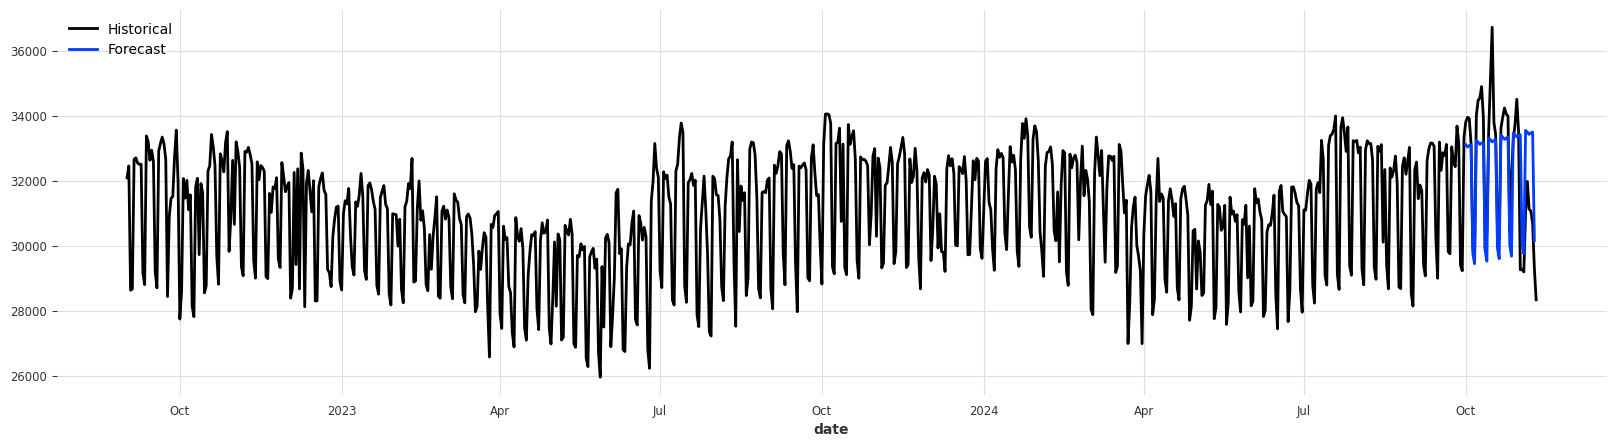

In [ ]:
from darts import TimeSeries
from darts.models import ExponentialSmoothing
from darts.metrics import mae, rmse, mape

series = TimeSeries.from_dataframe(total, value_cols='value') # creates timeseries
train, val = series.split_after(pd.Timestamp('2024-09-30')) # splits into training and test

model = ExponentialSmoothing()
model.fit(train)

forecast = model.predict(40)

error_mae = mae(val, forecast)
error_rmse = rmse(val, forecast)
error_mape = mape(val, forecast)

print(f"Mean Absolute Error (MAE): {error_mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {error_rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {error_mape:.2f}%")

plt.figure(figsize=(20, 5))
plt.title('Exponential smoothing')
series.plot(label = 'Historical', lw = 2)
forecast.plot(label = 'Forecast', lw = 2)
plt.legend()
plt.show()



# NBEATSModel

INFO:darts.models.forecasting.torch_forecasting_model:Train dataset contains 702 samples.
INFO:darts.models.forecasting.torch_forecasting_model:Time series values are 32-bits; casting model to float32.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.2 M  | train
----------------------------------------------------

Training: |          | 0/? [00:00<?, ?it/s]

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Mean Absolute Error (MAE): 1038.66
Root Mean Squared Error (RMSE): 1492.33
Mean Absolute Percentage Error (MAPE): 3.24%


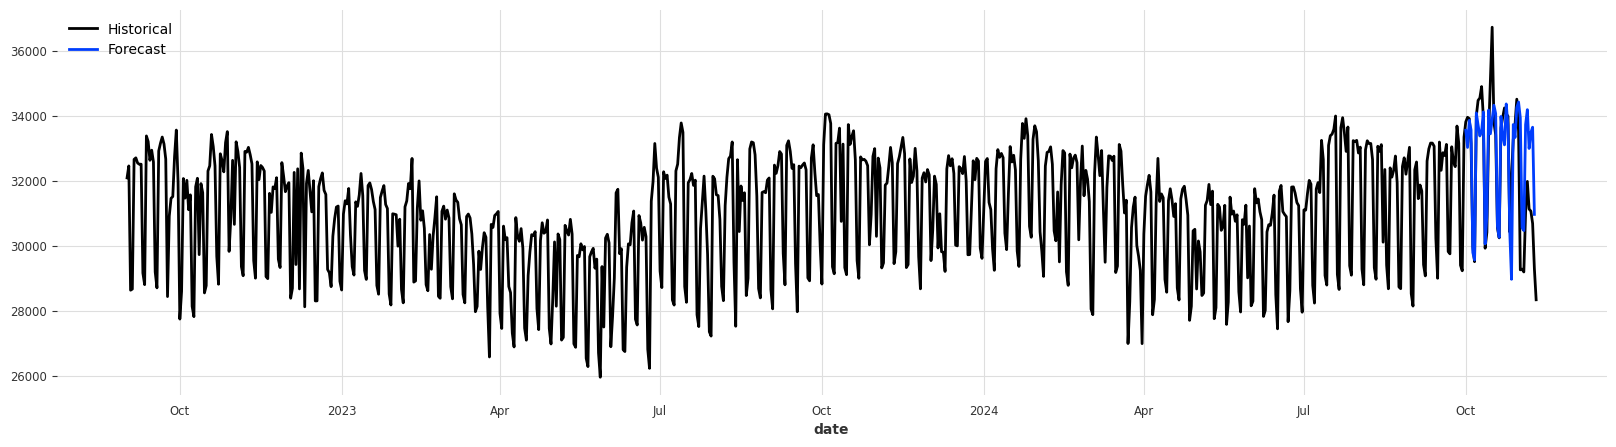

In [ ]:
from darts import TimeSeries
from darts.models import NBEATSModel
from darts.metrics import mae, rmse, mape

import torch

total['value'] = total['value'].astype(np.float32)

series = TimeSeries.from_dataframe(total, value_cols='value') # creates timeseries
series.astype(np.float32)

train, val = series.split_after(pd.Timestamp('2024-09-30')) # splits into training and test

NBEAT = NBEATSModel(
    input_chunk_length = 30,
    output_chunk_length = 30,
    n_epochs = 100,
    random_state = 42,
    # verbose = True
)
NBEAT.fit(train, verbose = True)

forecast = NBEAT.predict(40)

error_mae = mae(val, forecast)
error_rmse = rmse(val, forecast)
error_mape = mape(val, forecast)

print(f"Mean Absolute Error (MAE): {error_mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {error_rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {error_mape:.2f}%")

plt.figure(figsize=(20, 5))
plt.title('NBEATS')
series.plot(label = 'Historical', lw = 2)
forecast.plot(label = 'Forecast', lw = 2)
plt.legend()
plt.show()

# ARIMA

Mean Absolute Error (MAE): 1548.68
Root Mean Squared Error (RMSE): 1933.65
Mean Absolute Percentage Error (MAPE): 4.73%


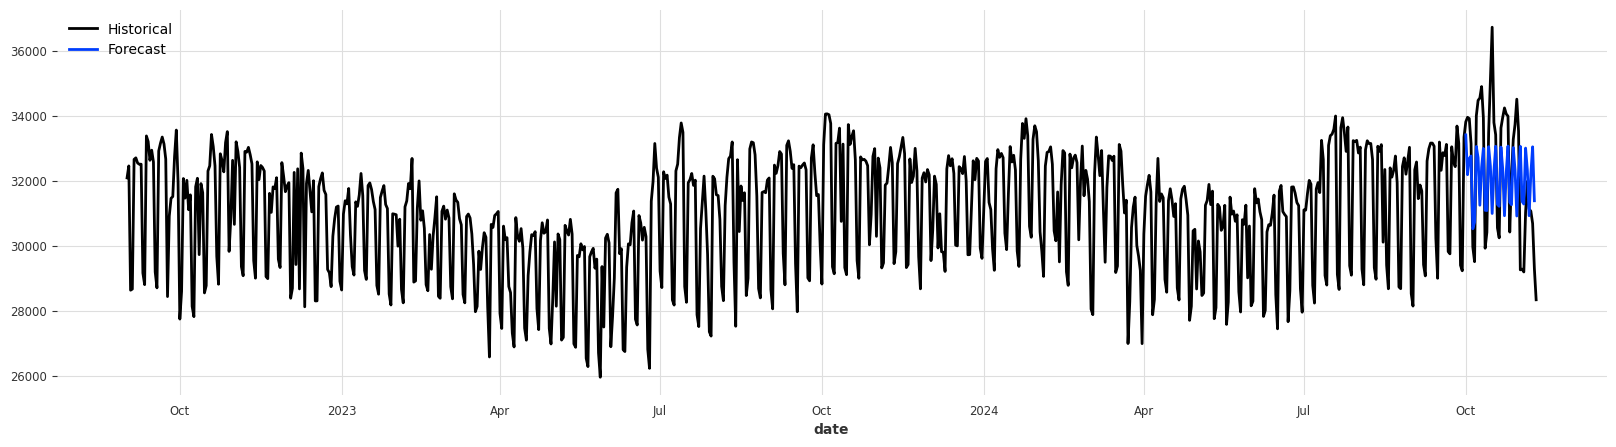

In [ ]:
from darts import TimeSeries
from darts.models import AutoARIMA
from darts.metrics import mae, rmse, mape

total['value'] = total['value'].astype(np.float32)

series = TimeSeries.from_dataframe(total, value_cols='value') # creates timeseries
series.astype(np.float32)

train, val = series.split_after(pd.Timestamp('2024-09-30')) # splits into training and test

ARIMA = AutoARIMA()
ARIMA.fit(train)

forecast = ARIMA.predict(40)

error_mae = mae(val, forecast)
error_rmse = rmse(val, forecast)
error_mape = mape(val, forecast)

print(f"Mean Absolute Error (MAE): {error_mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {error_rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {error_mape:.2f}%")

plt.figure(figsize=(20, 5))
plt.title('ARIMA')
series.plot(label = 'Historical', lw = 2)
forecast.plot(label = 'Forecast', lw = 2)
plt.legend()
plt.show()